# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

## Подготовка данных

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle 

In [3]:
data = pd.read_csv('/datasets/Churn.csv')
display(data.head(10))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Датасет содержит 10000 строк и 14 столбцов. Пропуски есть в столбце Tenure (сколько лет человек является клиентом банка). 
Что нам нужно сделать, чтобы подготовить данные к машинному обучению? 

Tenure - убрать пропуски, заменить на медианное или среднее значение. 
RowNumber — столбец по сути дублирует информацию стандартного датафрейма, то есть является идентификационным номером клиента, поэтому его можно удалить.   
CustomerId — аналогичная ситуация - значения столбца являются идентификатором пользователя. Проверим наличие дубликатов и если их не будет, то удалим столбец.   
Surname — данный столбец не несет никакой ценности для прогноза и для обучения будущей модели - можно удалить.   
Geography — проверим уникальные значения и затем, если понадбится выполним преобразование OHE / ordinal encoding.  
Gender — выполним преобразование OHE / ordinal encoding.  
Age — выполним преобразование OHE / ordinal encoding.  
Exited - выполним преобразование OHE / ordinal encoding.  

In [5]:
data.duplicated().sum()

0

In [6]:
data['CustomerId'].value_counts().sum()

10000

In [7]:
data['CustomerId'].duplicated().sum()

0

Дубликатов нет - можем удалять столбцы, которые нам не понадобятся.

In [8]:
data.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

In [9]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [10]:
print(data['Tenure'].mean())
print(data['Tenure'].median())

4.997690023099769
5.0


In [11]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
#data.info()

Посмотрим долю положительных и отрицательных ответов:

In [12]:
sum(data["Exited"]/len(data))

0.20369999999999389

In [13]:
1-sum(data["Exited"]/len(data))

0.7963000000000061

Доля отрицательных ответов больше, а значит, что в 20% случаев клиенты уходят из банка. 

Выполним прямое кодирование OHE, чтобы не попасться в дамми-ловушку, и чтобы в дальнейшем мы смогли обучить три модели - случайный лес, дерево решений и логистическую регрессию.

In [14]:
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Поле обозначения признаков, сформируем выборки: обучающую, валидационную и тестовую. Сначала разделим выборку на обучающую и валидационную в соотношении 60:40. Затем поделим валидационную на тестовую и валидационную пополам. В целом получится соотношение выборок 3:1:1.

In [15]:
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

In [16]:
features_train, features_validtest, target_train, target_validtest = train_test_split(features, target, 
                                                                              test_size=0.4, 
                                                                              random_state=1)

In [17]:
print(features_train.shape, target_train.shape, features_validtest.shape, target_validtest.shape)

(6000, 11) (6000,) (4000, 11) (4000,)


In [18]:
features_valid, features_test, target_valid, target_test = train_test_split(features_validtest,
                                                    target_validtest, 
                                                    train_size=0.5,
                                                    random_state=12345 
                                                   )

In [19]:
print(features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(2000, 11) (2000,) (2000, 11) (2000,)


Перейдем к масштабированию признаков. Для начала зафиксируем численные признаки, затем создадим объект этой структуры и настроим его на обучающих данных. И наконец масштабируем признаки на трех видах выборки. 

In [20]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [21]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
features_train[numeric] = scaler.transform(features_train[numeric])
pd.options.mode.chained_assignment = None
features_train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5834,1.481659,-0.658001,-1.083507,-1.229313,0.807406,1,0,1.639101,0,0,1
2959,-1.230388,-1.324330,1.448897,1.387941,-0.917820,1,0,-0.627157,0,0,1
2537,-0.786973,-0.562811,0.001809,0.221712,-0.917820,1,0,0.654565,0,0,0
166,0.563894,-1.419520,0.725353,0.590561,-0.917820,1,0,1.091898,1,0,0
9083,-2.292520,0.103519,1.087125,-1.229313,0.807406,1,1,-0.299652,0,1,1


In [23]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7402,-0.023888,-0.562811,0.725353,0.723001,0.807406,1,0,-0.398459,0,1,1
7561,-0.147631,0.198709,-0.359963,0.437781,0.807406,1,0,1.637859,0,0,1
5887,0.264847,-0.562811,-1.807052,1.053958,-0.917820,1,0,-0.615169,1,0,0
4426,0.594830,0.484279,0.363581,-1.229313,0.807406,1,1,1.616813,0,0,0
9200,0.924813,-0.848381,0.363581,-1.229313,-0.917820,0,0,0.394678,0,0,0


In [24]:
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5714,-0.982901,0.008329,1.810669,-1.229313,0.807406,1,1,-1.426395,0,0,0
7005,1.048557,0.389089,-1.445280,0.621796,-0.917820,1,0,0.452626,0,0,1
2213,-1.560371,0.198709,-0.359963,0.180116,0.807406,1,1,-1.528004,1,0,0
4995,1.626027,-0.277241,-0.359963,-1.229313,0.807406,0,1,0.821109,0,0,0
9241,-1.446939,-0.372431,1.087125,-1.229313,0.807406,0,1,-0.569451,0,0,1


#### Выводы

Мы подготовили данные для машинного обучения. Убрали пропуски, удалили ненужные столбцы, провели прямое кодирование данных OHE, разделили выборку на обучающую, валидационную и тестовую в соотношении 3:1:1. И наконец, провели масштабирование признаков. Перейдем к обучению модели и работе с балансом. 

## Исследование задачи

Создадим функцию, которая обучит три модели Случайный Лес, Дерево Решений, Логистическую Регрессию и посчитает их точность. 

In [25]:
def all_models_accuracy(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=123)
    DTC_score = model_DTC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    RFC_score = model_RFC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    LgR_score = model_LgR.fit(features_train, target_train).score(features_valid, target_valid)
    
    print("Точность:" "дерево решений", DTC_score, "случайный лес ", RFC_score, "логистическая регрессия", LgR_score)

In [26]:
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.7835 случайный лес  0.851 логистическая регрессия 0.799


Затем посмотрим, какой баланс у классов выборки. 

In [27]:
target_train.value_counts(normalize = 1)

0    0.800667
1    0.199333
Name: Exited, dtype: float64

In [28]:
target_valid.value_counts(normalize = 1)

0    0.78
1    0.22
Name: Exited, dtype: float64

Видим, что в обучающей и валидационной выборках есть заметный перевес в сторону отрицательных ответов. Есть вероятность, что модель будет чаще склоняться к этому ответу в предсказаниях. 

Теперь посмотрим, какое соотношение ответов выдает каждая модель, то есть проверим на адекватность. 

In [29]:
def all_models_share(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=123)
    model_DTC.fit(features_train, target_train)
    DTC_share = pd.Series(model_DTC.predict(features_valid)).value_counts(normalize = 1)
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    model_RFC.fit(features_train, target_train)
    RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    model_LgR.fit(features_train, target_train)
    LgR_share = pd.Series(model_LgR.predict(features_valid)).value_counts(normalize = 1)
    
    print("Доли ответов:" "дерево решений", DTC_share, "случайный лес ", RFC_share, "логистическая регрессия", LgR_share , end='')

In [30]:
all_models_share(features_train, target_train, features_valid, target_valid)

Доли ответов:дерево решений 0    0.7855
1    0.2145
dtype: float64 случайный лес  0    0.874
1    0.126
dtype: float64 логистическая регрессия 0    0.936
1    0.064
dtype: float64

Логистическая регрессия показала самый точный результат, но также данная модель будет показывать один вариант ответа "0" с вероятностью больше 90%.
Сравним качество предсказаний с константной моделью.

In [31]:
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.shape

(2000,)

In [32]:
accuracy_score_constant = accuracy_score(target_valid, target_predict_constant)
accuracy_score_constant

0.78

Ни одна модель не показала точность выше, чем у константной модели. Вероятно, проблема в дисбалансе классов. Посмотрим матрицу ошибок для каждой модели и разберемся с дисбалансом. 

**Матрица ошибок для модели Дерево Решений**

In [33]:
model_DTC = DecisionTreeClassifier(random_state=123)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)
confusion_matrix(target_valid, DTC_prediction)

array([[1349,  211],
       [ 222,  218]])

Дерево Решений чаще всего выдает правильные прогнозы. Создадим функцию, которая рассчитает нам полноту, точность и F1-меру.

In [34]:
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))
    print("AUC-ROC", roc_auc_score(target_valid, prediction))   

In [35]:
rec_prec_f1(target_valid, DTC_prediction)

Полнота 0.4954545454545455
Точность 0.5081585081585082
F1-мера 0.5017261219792866
AUC-ROC 0.6800990675990677


Низкое значние F1- меры говорит о низком качестве модели, проблема в точности.

**Матрица ошибок для модели Случайный Лес**

In [36]:
model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
confusion_matrix(target_valid, RFC_prediction)

array([[1505,   55],
       [ 243,  197]])

In [37]:
rec_prec_f1(target_valid, RFC_prediction)

Полнота 0.44772727272727275
Точность 0.7817460317460317
F1-мера 0.5693641618497111
AUC-ROC 0.7062354312354313


Случайный Лес аналогично имеет больше правильных прогнозов. Примерно равную пропорцию позитивных и негативных предсказаний, но также сильно склоняется к ложно позитивным предсказаниям. Низкое значние F1- меры говорит о низком качестве модели, проблема в точности.

**Матрица ошибок для модели Логистической Регрессии**

In [38]:
model_LgR = LogisticRegression(solver = 'liblinear')
model_LgR.fit(features_train, target_train)
LgR_prediction = model_LgR.predict(features_valid)
confusion_matrix(target_valid, LgR_prediction)

array([[1515,   45],
       [ 357,   83]])

In [39]:
LgR_probabilities_one_valid = model_LgR.predict_proba(features_valid)[:, 1]

auc_roc_LgR = roc_auc_score(target_valid, LgR_probabilities_one_valid)

auc_roc_LgR

0.7407415501165501

Для логистической регрессии расчитали метрику AUC-ROC. Метрика лучше, чем у случайной модели, но все равно не идеально. Построим ROC-кривую и попробуем обучить Логистическую Регрессию, но уже сбалансировав классы. 

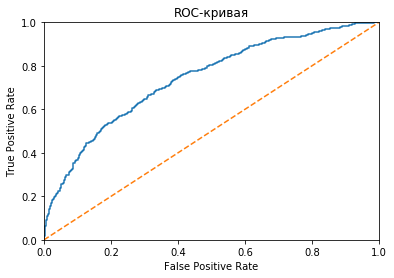

In [40]:
fpr, tpr, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Score 0.709
AUC-ROC 0.7460052447552448


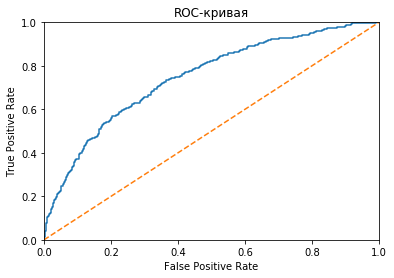

In [41]:
model_LgR = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_LgR.fit(features_train, target_train)
LgR_probabilities_one_valid_class_weight = model_LgR.predict_proba(features_valid)[:, 1]
print("Score", model_LgR.score(features_valid, target_valid))
print("AUC-ROC", roc_auc_score(target_valid, LgR_probabilities_one_valid_class_weight))

fpr, tpr, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid_class_weight) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

ТОчность предсказаний не улучшилась..Высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке. Поэтому переходим к балансировке выборок. 

#### Выводы 

На данном этапе мы обучили три модели Случайный Лес, Дерево Решений и Логистическая Регрессия. Обнаружили дисбаланс классов и низкое значние F1- меры, что говорит о низком качестве модели, то есть проблема в точности. Приступим к работе с дисбалансом, чтобы сделать наши модели намного точнее и качественнее. 

## Борьба с дисбалансом ##

В нашей выборке отрицательны ответов ≈80% , положитительных ≈ 20%. Нам нужно увеличить количество положительных ответов в 4 раза, чтобы был достигнут баланс.

Для этого разделим обучающую выборку на отрицательные и положительные объекты, скопируем несколько раз положительные объекты.
С учётом полученных данных создадим новую обучающую выборку и перемешаем данные.

In [42]:
target_train.value_counts(normalize = 1)

0    0.800667
1    0.199333
Name: Exited, dtype: float64

Увеличиваем число наблюдений положительного класса с помощью техники  upsampling.

In [43]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [44]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.501043
1    0.498957
Name: Exited, dtype: float64
(9588,)


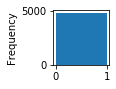

In [45]:
target_train_upsampled.plot(kind ='hist', 
                            bins=2, 
                            figsize=(1,1))
plt.show()

In [46]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [47]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, fraction=0.25)

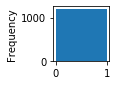

In [48]:
target_train_downsampled.plot(kind ='hist', 
                              bins=2, 
                              figsize=(1,1))
plt.show()

Мы получили сбалансированную выборку c помощью техник upsampling и downsampling, теперь можно обучать модели. Но для начала посмотрим, как изменилась точность моделей на сбалансированной выборке. 

In [49]:
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.7835 случайный лес  0.851 логистическая регрессия 0.799


In [50]:
all_models_accuracy(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

Точность:дерево решений 0.7765 случайный лес  0.848 логистическая регрессия 0.7085


In [51]:
all_models_accuracy(features_train_downsampled, target_train_downsampled, features_valid, target_valid)

Точность:дерево решений 0.7005 случайный лес  0.784 логистическая регрессия 0.701


Точность изменилась, но не сильно. C уменьшенной выборкой точность стала еще ниже. Проверим качество предсказаний. 

In [52]:
model_DTC_upsampled = DecisionTreeClassifier(random_state=123)
model_DTC_upsampled.fit(features_train_upsampled, target_train_upsampled)
DTC_prediction_upsampled = model_DTC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, DTC_prediction_upsampled)

Полнота 0.45454545454545453
Точность 0.4914004914004914
F1-мера 0.4722550177095632
AUC-ROC 0.6609265734265735


In [53]:
model_RFC_upsampled = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
RFC_prediction_upsampled = model_RFC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, RFC_prediction_upsampled)

Полнота 0.5204545454545455
Точность 0.7111801242236024
F1-мера 0.6010498687664042
AUC-ROC 0.7304195804195804


In [54]:
model_LgR_upsampled = LogisticRegression(solver = 'liblinear')
model_LgR_upsampled.fit(features_train_upsampled, target_train_upsampled)
LgR_prediction_upsampled = model_LgR_upsampled.predict(features_valid)
rec_prec_f1(target_valid, LgR_prediction_upsampled)

Полнота 0.625
Точность 0.3968253968253968
F1-мера 0.4854368932038835
AUC-ROC 0.6785256410256411


Показатели у всех моделей стали лучше.
Лучшие результаты показывает алгоритм Случайный Лес. На валидационной выборке RandomForestClassifier уже показывает резульаты F1 меры = 0.60, что выше целевого целевого значения.
Протестируем лучшую модель. 

## Тестирование модели

Обучим финальную модель, которая имеет наилучшее значение метрики F-1. Затем проведем все необходимые рассчеты на тестовой выборке. 

In [56]:
model_RFC_final = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC_final.fit(features_train_upsampled, target_train_upsampled)
model_RFC_final_prediction = model_RFC_final.predict(features_valid)
rec_prec_f1(target_valid, model_RFC_final_prediction)

Полнота 0.5204545454545455
Точность 0.7111801242236024
F1-мера 0.6010498687664042
AUC-ROC 0.7304195804195804


In [57]:
model_RFC_final
model_RFC_final_prediction = model_RFC_final.predict(features_test)
rec_prec_f1(target_test, model_RFC_final_prediction)

Полнота 0.5536159600997507
Точность 0.683076923076923
F1-мера 0.6115702479338843
AUC-ROC 0.7446003502812699


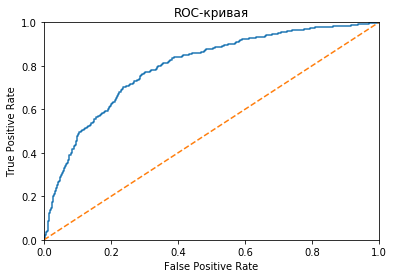

In [58]:
final_model_probabilities_one = model_LgR.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Выводы 
Финальная модель достигла заданой метрики F1 > 0.59 и показала адекватные результаты.  
Модель характеризуется средним показателем полноты = 0.55 (min = 0, max = 1), поэтому она равновероятностно спрогнозирует два варианта событий - уход клиента из банка или то, что он останется в банке.   
Показатель точности высокий = 0.68 (min = 0, max = 1) — модель может верно предсказать уход клиентов из банка. 
Важно, что модель покрывает большое количество клиентов, в данном случае это важнее чем точность.